# Calculating Tr$\left(\rho^{2}\right)$ from VQE data

In this notebook, we will take quantum circuits built via VQE, and append them to the overlap quantum circuits. 

In [92]:
from sys import path
path.insert(0, '..')
path.insert(0, '../../vqe')

from bba import *
from swap import *
from utilities import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
import variational_form as vf
from qiskit.quantum_info import partial_trace,entropy

The pickled data files contain lists of quantum circuit configurations, with each element describing a disorder configuration. Below is a function that takes in parameters describing the system, and returns a list of quantum circuits.

In [93]:
def load_data(dir_name, W, num_qubits, entanglement, reps):
    fname="{}W{}_q{}_VVQE_SLSQP_{}_rep{}.pkl".format(dir_name, W, num_qubits, entanglement, reps)
    with open(fname,'rb') as f:
        vqe_list = pickle.load(f)
        qc_list = [None]*len(vqe_list)
        for i, vqe in enumerate(vqe_list):
            ansatz = vf.sz_conserved_ansatz(num_qubits, entanglement=entanglement, reps=reps)
            params = sorted(ansatz.parameters, key=lambda p: p.name) 
            params = dict(zip(params, vqe['opt_params'])) 
            qc_list[i] = ansatz.assign_parameters(params)
    return qc_list

Now let's load in some data for $n=6$ qubits, and $W$ ranging from 1 to 8.

In [94]:
num_qubits = 6
entanglement='sca'
reps=2
dir_name ="../../../results/vvqe/" 
qc_dict = {}
W_list = [1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8]
for W in W_list:
    print("W={}".format(W))
    qc_dict[W] = load_data(dir_name, W, num_qubits, entanglement, reps)
pickle.dump(qc_dict, open( "qc_dict_q{}_VVQE_SLSQP_{}_rep{}.pkl".format(num_qubits, entanglement, reps), "wb" ) )

W=1
W=1.5
W=2
W=2.5
W=3
W=4
W=5
W=6
W=7
W=8


Now we connect this circuit to our overlap implementations and collect the second renyi entropys for all disorder and W.

In [95]:
import time
def run_vqe_overlap(qc_dict, overlap_func, L_a, shots=1000, noise=None, verbose=False):
    ent_dict = {}
    for W in qc_dict.keys():
        print("W={}".format(W))
        qc_list = qc_dict[W]
        o_list = []
        for i in range(len(qc_list)):
            psi = qc_list[i]
            s = time.time()
            overlap = overlap_func(psi, psi, list(range(L_a)), shots=shots, backend="qasm_simulator", noise=noise)
            e = time.time()
            if verbose:
                print("i: {} time: {}".format(i, e - s))
            o_list.append(-np.log2(overlap))
        ent_dict[W] = o_list
    return ent_dict

In [96]:
sw_ent_dict_list = []
for L_a in range(1, num_qubits//2 +1):
    print(L_a)
    sw_ent_dict_list.append(run_vqe_overlap(qc_dict, bba_overlap, L_a, shots=10000, noise=None, verbose=False))
pickle.dump(sw_ent_dict_list, open( "sw_ent_dict_list_q{}_VVQE_SLSQP_{}_rep{}.pkl".format(num_qubits, 'sca', 2), "wb" ) )

1
W=1
W=1.5
W=2
W=2.5
W=3
W=4
W=5
W=6
W=7
W=8
2
W=1
W=1.5
W=2
W=2.5
W=3
W=4
W=5
W=6
W=7
W=8
3
W=1
W=1.5
W=2
W=2.5
W=3
W=4
W=5
W=6
W=7
W=8


Now we compare the overlaps obtained via BBA with the ones computed using the state vector from the original data.

In [97]:
def get_exact_entropies(qc_dict, L_a):

    backend = Aer.get_backend("statevector_simulator")
    ent_dict = {}
    for W in qc_dict.keys():
        print("W={}".format(W))
        qc_list = qc_dict[W]
        o_list = []
        for i in range(len(qc_list)):
            job = execute(qc_list[i], backend)
            vec = job.result().get_statevector(qc_list[i])
            rho = partial_trace(vec,range(L_a))
            ent = -np.log2((rho.data@rho.data).trace().real)
            o_list.append(ent)
        ent_dict[W] = o_list
    return ent_dict

In [98]:
exact_ent_dict = [get_exact_entropies(qc_dict, L_a) for L_a in range(1, num_qubits//2+1)]

W=1
W=1.5
W=2
W=2.5
W=3
W=4
W=5
W=6
W=7
W=8
W=1
W=1.5
W=2
W=2.5
W=3
W=4
W=5
W=6
W=7
W=8
W=1
W=1.5
W=2
W=2.5
W=3
W=4
W=5
W=6
W=7
W=8


<IPython.core.display.Javascript object>


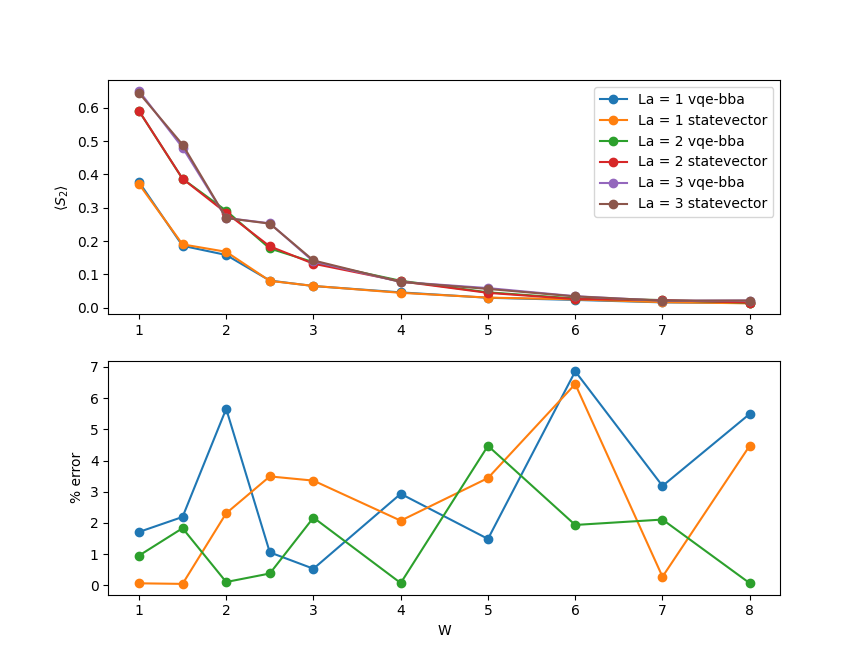

<ipython-input-105-69c971337923>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(211)
<ipython-input-105-69c971337923>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(212)
<ipython-input-105-69c971337923>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retu

In [105]:
%matplotlib notebook

for La_idx in range(num_qubits//2):
    avg_o_list = [np.median(sw_ent_dict_list[La_idx][W]) for W in sw_ent_dict_list[La_idx].keys()]
    avg_oe_list = [np.median(exact_ent_dict[La_idx][W]) for W in exact_ent_dict[La_idx].keys()]

    error_list = [np.abs((a - b)/b)*100 for (a,b) in zip(avg_o_list, avg_oe_list)]
    plt.subplot(211)
    plt.plot(W_list, avg_o_list, 'o-', label='La = {} vqe-bba'.format(La_idx+1))
    plt.plot(W_list, avg_oe_list, 'o-', label='La = {} statevector'.format(La_idx+1))

    plt.subplot(212)
    plt.plot(W_list, error_list, 'o-', label="La = {}".format(La_idx+1))
    
plt.subplot(211)
plt.ylabel(r"$\left<S_{2}\right>$")
plt.legend(loc='best')
plt.subplot(212)
plt.ylabel("% error")
plt.xlabel("W")
plt.show()